# Shelter Intake and Outcome Analysis
## Notebook 3: Predictive Modeling & Insights
This notebook builds predictive models to understand which factors influence outcomes and length of stay at the Austin Animal Center. It includes feature engineering, model training, evaluation, and interpretation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

df=pd.read_csv('../processed/aac_cleaned.csv')
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,...,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,outcome_category
0,10 years,a006100,2007-07-09 00:00:00,return to owner,neutered male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,...,2017-12-07 00:00:00,12,2017,2017-12,thursday,14,1.0,0 days 14:07:00.000000000,0.588194,positive
1,7 years,a006100,2007-07-09 00:00:00,return to owner,neutered male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,...,2014-12-19 10:21:00,12,2014,2014-12,friday,10,2.0,1 days 06:14:00.000000000,1.259722,positive
2,6 years,a006100,2007-07-09 00:00:00,return to owner,neutered male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,3,...,2014-03-07 14:26:00,3,2014,2014-03,friday,14,3.0,1 days 02:44:00.000000000,1.113889,positive
3,10 years,a047759,2004-04-02 00:00:00,transfer,neutered male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,...,2014-04-02 15:55:00,4,2014,2014-04,wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,positive
4,16 years,a134067,1997-10-16 00:00:00,return to owner,neutered male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,...,2013-11-16 09:02:00,11,2013,2013-11,saturday,9,1.0,0 days 02:52:00.000000000,0.119444,positive


In [2]:
# Define Target
df['target'] = (df['outcome_category'] == 'positive').astype(int)
df['target'].value_counts()

target
1    72173
0     7464
Name: count, dtype: int64

In [3]:
features = [
    'animal_type',
    'breed',
    'sex_upon_intake',
    'age_upon_intake',
    'time_in_shelter_days',
    'intake_month'
]

X = df[features].copy()
y = df['target']

In [4]:
categorical_cols = ['animal_type', 'breed', 'sex_upon_intake']

for col in categorical_cols:
    X[col] = X[col].fillna('Unknown')

In [5]:
numeric_cols = ['age_upon_intake', 'time_in_shelter_days', 'intake_month']

for col in numeric_cols:
    X[col] = pd.to_numeric(X[col], errors='coerce')
    X[col] = X[col].fillna(X[col].median())

In [6]:
X.isna().sum()

animal_type             0
breed                   0
sex_upon_intake         0
age_upon_intake         0
time_in_shelter_days    0
intake_month            0
dtype: int64

In [7]:
# Fill missing values
X['age_upon_intake'] = X['age_upon_intake'].fillna(X['age_upon_intake'].median())

In [8]:
X['age_upon_intake'].describe()
X['age_upon_intake'].apply(type).value_counts()

age_upon_intake
<class 'float'>    79637
Name: count, dtype: int64

In [9]:
X.isna().sum()

animal_type             0
breed                   0
sex_upon_intake         0
age_upon_intake         0
time_in_shelter_days    0
intake_month            0
dtype: int64

In [10]:
# Train/Test/Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# Preprocessing Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

In [ ]:
# Build/Train Random Forest Model
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

model.fit(X_train, y_train)


Random forest modeling was selected as the primary model because it handles mixed data types, high cardinality categorical features, and nonlinear relationships extremely well. The shelter data includes complex interactions between breed, age, intake month, and time in shelter, and Random Forest can capture these patterns without extensive preprocessing or feature engineering. It is also robust to noise and missing values, which are common in real-world animal intake data. Finally, Random Forest provides interpretable feature importances, allowing the model to support actionable insights for shelter operations. 

              precision    recall  f1-score   support

           0       0.86      0.61      0.71      1493
           1       0.96      0.99      0.98     14435

    accuracy                           0.95     15928
   macro avg       0.91      0.80      0.84     15928
weighted avg       0.95      0.95      0.95     15928



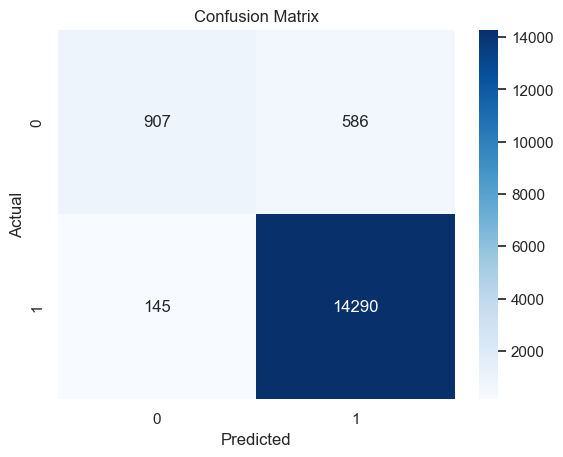

<Figure size 640x480 with 0 Axes>

In [ ]:
# Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.savefig('../images/confusion_matrix.png', dpi=300, bbox_inches='tight')

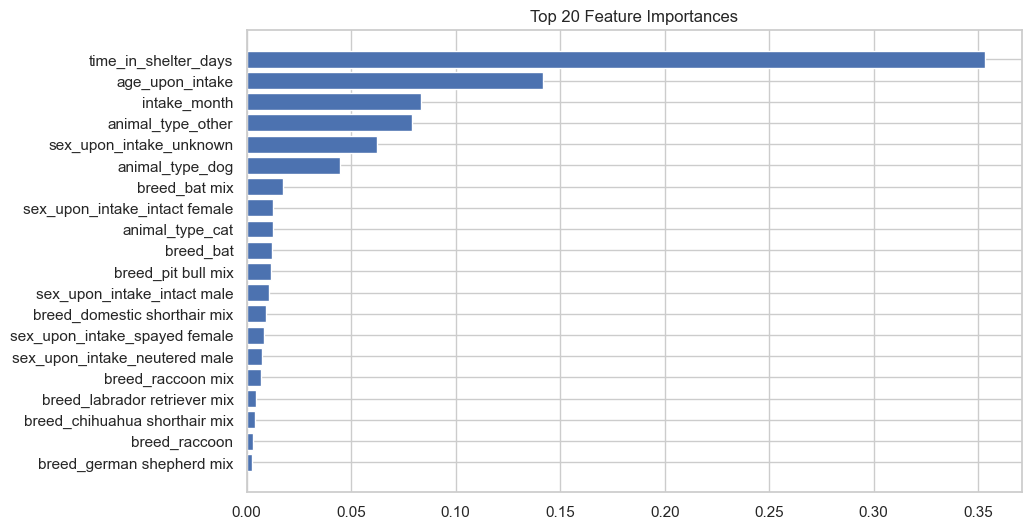

<Figure size 640x480 with 0 Axes>

In [ ]:
# Feature Importance

ohe = model.named_steps['preprocess'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([cat_features, numeric_cols])

importances = model.named_steps['rf'].feature_importances_

indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10,6))
plt.barh(all_features[indices], importances[indices])
plt.title('Top 20 Feature Importances')
plt.show()
plt.savefig('../images/feature_importance.png', dpi=300, bbox_inches='tight')

## What the Model Learned About Shelter Outcomes
Our Random Forest model has ranked the predictors based on how much they contribute to correctly classifying an outcome as positive (adopted, returned to owner, transferred) versus negative (euthanized, died, etc). 

### Time in Shelter is One of the Strongest Predictors
Our model shows us that animals with shorter shelter stays are far more likely to have positive outcomes. This makes logical sense as animals adopted quickly tend to be the healthiest, more behaviorally stable, and most appealing to adopters. Longer stays often correlate with medical issues, behavioral challenges, or low adopter interest. 

### Age at Intake Strongly Influences Outcomes
We can see that younger animals such as kittens and puppies are more likely to have positive outcomes, and as age increases, the lower the likelihood the animal has to get adopted. 

### Breed Has a Significant Predictive Role 
Breed is a high-cardinality feature which is handled well by Random Forest modeling. Some patterns that we can see include the more highly adoptable breeds such as popular smaller dogs, tend to push predictions toward positive outcomes. Breeds associated with stigma or special care needs may push predictions toward negative outcomes. While this doesn't mean that breed determines fate within the shelter, it moreso reflects adopter behavior and shelter restraints. 

### Animal Type Matters
Cats and dogs showed different outcomes. The model discovered that dogs tend to have higher return-to-owner rates, and cats have higher adoption variability. 

### Sex Upon Intake Has Predictive Value
This feature shows that animals who have already been spayed or neutered have higher positive outcomes, while intact animals have slightly lower positive outcomes. This is largely due to the fact that in the eyes of adopters, spayed and neutered animals are often seen as "ready to adopt", while intact animals may require surgery, delaying adoption or introducing medical risk. 

### Intake Month Captures Seasonal Trends
Shelters see strong seasonal patterns. For example, the spring and summer time, or what is commonly referred to as "kitten season", show a large spike in intakes. In general, shelters may see lower adoption traffic in the winter, with positive outcomes spiking around the holidays due to holiday adoptions. 

## Insights

- Reducing the length of stay can directly improve outcomes. 
- Shelters can focus on targeted programs to increase positive outcomes for groups with less-desirable traits or lower adoptability. For example, introducing senior-pet adoption campaigns, finding medical support for older animals, or creating age-specific foster programs. 
- Shelters can increase positive outcomes with pre-adoption spay and neuter programs. 
- Planning for seasonal trends can help optimize shelter operations, such as planning staffing during busier seasons, recruiting more fosters, and implementing various adoption events. 